# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [24]:
# Import your libraries:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [25]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')
customers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [35]:
#.1 Data types of each column, therefore no categorical data to convert into numerical ones

customers.dtypes
customers.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [34]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [27]:
#2. Check if there is any missing value in the dataset

customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [28]:
#3. Check and count the unique values of each column of the dataset

customers.value_counts()
customers.nunique()

Channel               2
Region                3
Fresh               433
Milk                421
Grocery             430
Frozen              426
Detergents_Paper    417
Delicassen          403
dtype: int64

In [29]:
customers['Channel'].unique()

array([2, 1])

In [30]:
customers['Region'].unique()

array([3, 1, 2])

In [47]:
#4. Check the correlation among the different columns

customers.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690,0.169172,-0.169172,-0.032760,-0.057832,0.067375
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368,-0.460720,0.460720,-0.019358,-0.033217,0.039156
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497,-0.608792,0.608792,-0.026598,0.046170,-0.009235
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947,0.202046,-0.202046,-0.006800,0.069421,-0.041920
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291,-0.636026,0.636026,-0.022279,0.058526,-0.021366
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000,-0.056011,0.056011,-0.027791,-0.044831,0.054252
Channel_1,0.169172,-0.460720,-0.608792,0.202046,-0.636026,-0.056011,1.000000,-1.000000,0.087638,-0.060306,-0.032613
Channel_2,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011,-1.000000,1.000000,-0.087638,0.060306,0.032613
Region_1,-0.032760,-0.019358,-0.026598,-0.006800,-0.022279,-0.027791,0.087638,-0.087638,1.000000,-0.159274,-0.735233
Region_2,-0.057832,-0.033217,0.046170,0.069421,0.058526,-0.044831,-0.060306,0.060306,-0.159274,1.000000,-0.552059


### Some visualization with a boxplot and correlation matrix
- Boxplot to show if there are any outliers
- Correlation plot to show the cardinality among the different columns
- Verify if there are some outliers, by checking if there is any value is lower than the Q1 and Q3

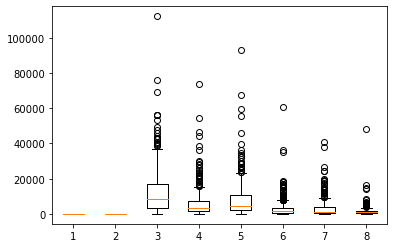

In [37]:
plt.boxplot(customers.values)
plt.show()

In [40]:
cc = customers.corr()
cc[(cc > 0.8) & (cc < 1)].any()
# Grocery x Detergents_Paper

Channel             False
Region              False
Fresh               False
Milk                False
Grocery              True
Frozen              False
Detergents_Paper     True
Delicassen          False
dtype: bool

/var/folders/vy/72w35wd12ms4_h7n214795k40000gn/T/ipykernel_10644/4237668849.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


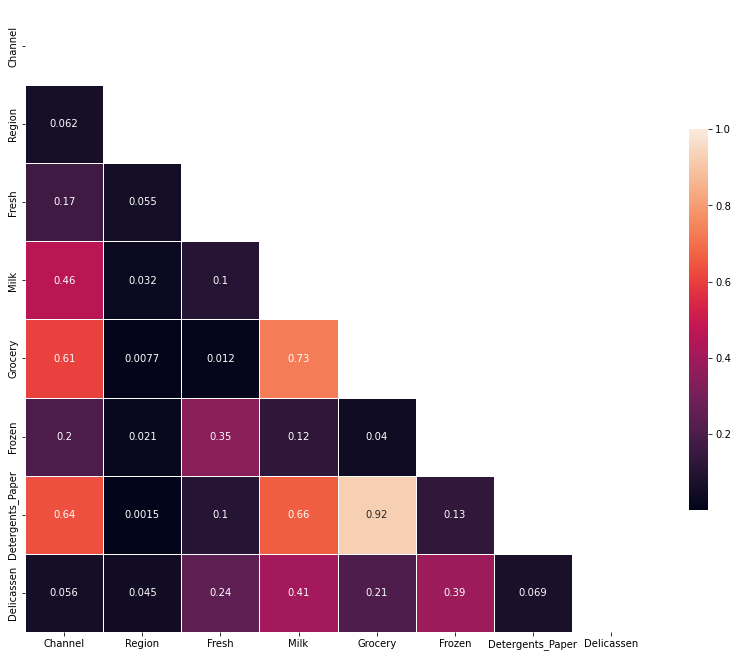

In [31]:
# Heatmap to show correlation among the columns of our dataframe
corr = np.abs(customers.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [41]:
categorical_features = ['Channel', 'Region']
other_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

for col in categorical_features:
    dummies = pd.get_dummies(customers[col], prefix=col) #we want to create dummies for each categorical feature
    customers = pd.concat([customers, dummies], axis=1) #we want to concatenate the dummies created to the original dataframe customer, along the columns
    customers.drop(col, axis=1, inplace=True) #we want to drop the original columns which are classified as categorical features, since dummies were created 
    #for each of their unique values
    
customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


/var/folders/vy/72w35wd12ms4_h7n214795k40000gn/T/ipykernel_10644/1344249050.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


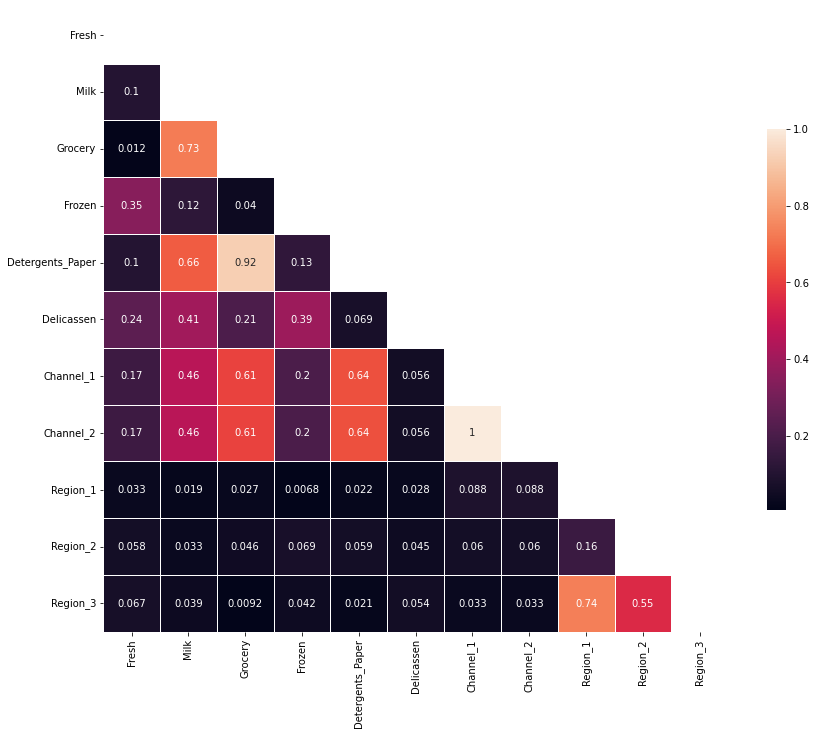

In [42]:
# Heatmap to show correlation among the columns of our dataframe, after having dropped the original categorical_features
corr = np.abs(customers.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [44]:
# When looking at the new coorelation matrix, we can see that the Region doesn't afect our features in a considerable way therefore we decide to drop these columns from our
# new dataframe, customers_transformed

columns_to_drop = ['Region_1','Region_2','Region_3']

In [45]:
customers_transformed = customers.drop((columns_to_drop), axis=1)
customers_transformed.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2
0,12669,9656,7561,214,2674,1338,0,1
1,7057,9810,9568,1762,3293,1776,0,1
2,6353,8808,7684,2405,3516,7844,0,1
3,13265,1196,4221,6404,507,1788,1,0
4,22615,5410,7198,3915,1777,5185,0,1


# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [48]:
# Your import here:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [60]:
# Create an empty model

scaler = StandardScaler()

# Train the model with dataset customers_transformed
scaler.fit(customers_transformed)

StandardScaler()

In [61]:
customer_scaler = scaler.transform(customers_transformed)
customer_scaler

array([[ 0.05293319,  0.52356777, -0.04111489, ..., -0.06633906,
        -1.44865163,  1.44865163],
       [-0.39130197,  0.54445767,  0.17031835, ...,  0.08915105,
        -1.44865163,  1.44865163],
       [-0.44702926,  0.40853771, -0.0281571 , ...,  2.24329255,
        -1.44865163,  1.44865163],
       ...,
       [ 0.20032554,  1.31467078,  2.34838631, ...,  0.12145607,
        -1.44865163,  1.44865163],
       [-0.13538389, -0.51753572, -0.60251388, ...,  0.21304614,
         0.69029709, -0.69029709],
       [-0.72930698, -0.5559243 , -0.57322717, ..., -0.52286938,
         0.69029709, -0.69029709]])

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [65]:
from sklearn.cluster import KMeans

kmeans = KMeans()
kmeans.fit(customer_scaler)
customers_transformed['labels'] = kmeans.labels_


Count the values in `labels`.

In [66]:
customers_transformed['labels'].value_counts()

6    178
0    100
1     89
4     37
7     28
2      5
5      2
3      1
Name: labels, dtype: int64

In [67]:
from sklearn.metrics import silhouette_score

data = customers_transformed.drop(columns=['labels'], axis=1)
target = customers_transformed['labels']

score = silhouette_score(data, target, metric='euclidean')
score

0.21763541442593332

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [70]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=0.5)
dbscan_model.fit(customer_scaler)
customers_transformed['labels_DBSCAN'] = dbscan_model.labels_


Count the values in `labels_DBSCAN`.

In [72]:
customers_transformed['labels_DBSCAN'].value_counts()

 1    201
-1    194
 0     32
 3      8
 2      5
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

In [73]:
target_kmeans = customers_transformed['labels']
score_kmeans = silhouette_score(data, target_kmeans, metric='euclidean')
print(score_kmeans)

0.21763541442593332


In [74]:
target_dbscan = customers_transformed['labels_DBSCAN']
score_dbscan = silhouette_score(data, target_dbscan, metric='euclidean')
print(score_dbscan)

-0.1313098063387462


Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

In [ ]:
# Your code here:


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

In [ ]:
# Your code here:

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [75]:
customers_transformed.groupby(['labels','labels_DBSCAN']).mean()

Fresh          Milk       Grocery        Frozen  \
labels labels_DBSCAN                                                           
0      -1             10670.016667   7177.033333  11694.250000   2024.066667   
        0              4838.500000   6644.593750  10277.156250    784.593750   
        3             14726.625000   6636.125000   7003.625000    961.375000   
1      -1             17591.657143   5847.857143   5869.371429   7605.971429   
        1             17735.648148   1903.648148   2483.425926   4344.018519   
2      -1             25603.000000  43460.600000  61472.200000   2636.000000   
3      -1             36847.000000  43950.000000  20170.000000  36534.000000   
4      -1              6041.972973  16435.189189  24971.108108   1817.540541   
5      -1             22015.500000   9937.000000   7844.000000  47939.000000   
6      -1              4942.129032   5968.193548   7165.064516   2011.612903   
        1              6510.129252   2176.238095   2747.197279   1514.081633   
7      -1             45390.347826   6317.000000   7327.521739   8368.217391   
        2             41446.600000   1421.200000   2167.600000   1276.400000   

                      Detergents_Paper    Delicassen  Channel_1  Channel_2  
labels labels_DBSCAN                                                        
0      -1                  4667.833333   1768.966667        0.0        1.0  
        0                  4776.093750   1004.843750        0.0        1.0  
        3                  2583.625000   1951.875000        0.0        1.0  
1      -1                   819.514286   1943.971429        1.0        0.0  
        1                   396.333333    909.481481        1.0        0.0  
2      -1                 29974.200000   2708.800000        0.0        1.0  
3      -1                   239.000000  47943.000000        1.0        0.0  
4      -1                 11589.864865   2203.675676        0.0        1.0  
5      -1                   671.500000   4153.500000        1.0        0.0  
6      -1                  2187.612903   1770.548387        1.0        0.0  
        1                   595.639456    713.346939        1.0        0.0  
7      -1                  1150.608696   3690.478261        1.0        0.0  
        2                   416.200000    784.800000        1.0        0.0

In [77]:
print(customers_transformed.groupby('labels').mean())

print(customers_transformed.groupby('labels_DBSCAN').mean())

               Fresh          Milk       Grocery        Frozen  \
labels                                                           
0        9128.460000   6963.380000  10865.530000   1542.420000   
1       17679.022472   3454.741573   3814.977528   5626.808989   
2       25603.000000  43460.600000  61472.200000   2636.000000   
3       36847.000000  43950.000000  20170.000000  36534.000000   
4        6041.972973  16435.189189  24971.108108   1817.540541   
5       22015.500000   9937.000000   7844.000000  47939.000000   
6        6237.050562   2836.634831   3516.601124   1600.730337   
7       44686.107143   5442.750000   6406.107143   7101.821429   

        Detergents_Paper    Delicassen  Channel_1  Channel_2  labels_DBSCAN  
labels                                                                       
0            4535.740000   1539.080000        0.0        1.0      -0.360000  
1             562.752809   1316.303371        1.0        0.0       0.213483  
2           29974.200000   

Which algorithm appears to perform better?

In [ ]:
# Your observations here

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here